# Image classification for vehicle body type

### Summary

The goal is to recognize a body type for a vehicle in order to infer a CO2 emission


## Libraries

In [3]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
from PIL import Image
sys.modules['Image'] = Image 

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# due to error : failed to initialize cudnn
config = ConfigProto()
config.gpu_options.allow_growth = True
try:
    session.close()
except:
    pass
session = InteractiveSession(config=config)

import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Data visualization
from matplotlib import pyplot as plt

from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


## Dataset

The dataset used in this TP is the build from a scraper we crated.
Each subdirectory of `data/vehicle_images` represents a body type to recognize


### Dataset organisation

To use some of the image generators of keras, that we will used later, we have to organise the dataset so that each data of a same class are within the same folder. 

Our data are then organized this way :

```
data
└───vehicle_images/
│   └───train/
│   │   └───berline/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   │   └───break/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   └───validation/
│   │   └───berline/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   │   └───break/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
```

###  Parameter

In [4]:
path_data = '../data/vehicle_images' # data path
path_data_train = path_data + '/train'
path_data_val = path_data + '/val'

car_body_types = ['berline', 'break', 'cabriolet', 'combispace', 'coupe', 'minibus', 'minispace', 'monospace', 'monospace compact', 'tous-terrains']

### Illustration of the data

The `load_img` function allows to load an image as a PIL image.

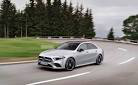

In [3]:
img = kpi.load_img(path_data_train + '/berline/0001.jpg')  # this is a PIL image
img

The function `img_to_array` generates an `array numpy` from a  PIL image.

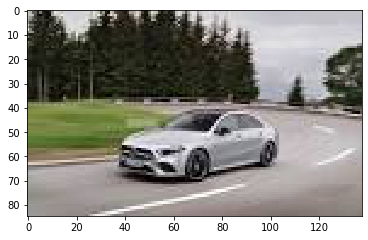

In [4]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

## Pre-processing

The `ImageDataGenerator` `keras`function allows to apply different treatments on the images (transformation, normalisation). This  transformation allows to increase the size of the dataset and to make the classifier more robust.

All the possible transformations are listed in the documentation of the function.

In [5]:
datagen = kpi.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

The`.flow()` command generates transformed images from an original image and saves its in the specified directory.

In the following code we produce 8 of these transformed images.

In [6]:
path_preprocessing_ex = path_data + "/preprocessing_example"
img = kpi.load_img(path_data_train + '/berline/0001.jpg')  # this is a PIL image
x = kpi.img_to_array(img)
x_ = np.expand_dims(x, axis=0)

if not(os.path.isdir(path_preprocessing_ex)):
    os.mkdir(path_preprocessing_ex)

    i = 0
    for batch in datagen.flow(x_, batch_size=1, save_to_dir=path_preprocessing_ex, save_prefix='berline', save_format='jpeg'):
        i += 1
        if i > 7:
            break

Display transformed images

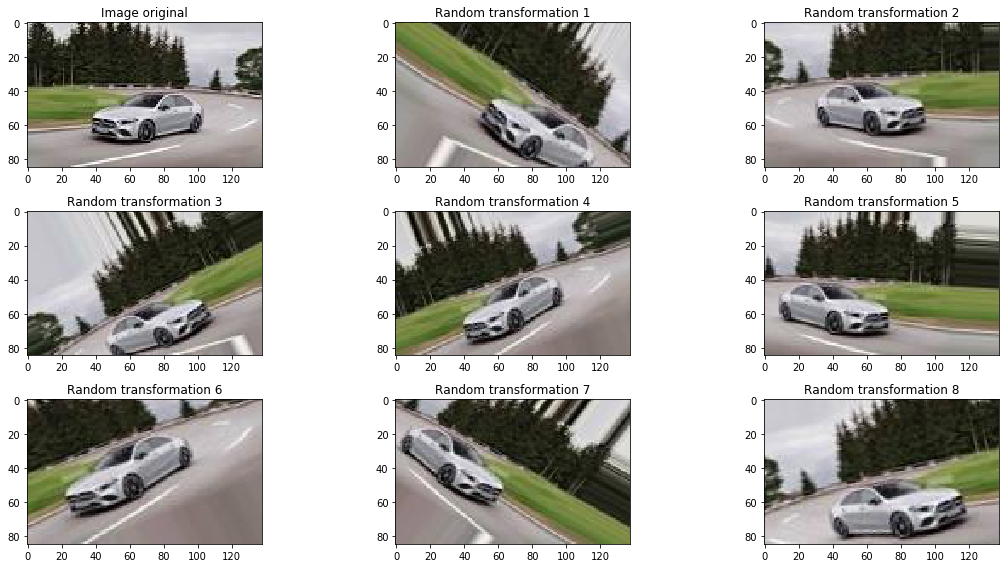

In [7]:
X_list = []
for f in os.listdir(path_preprocessing_ex):
    X_list.append(kpi.img_to_array(kpi.load_img(path_preprocessing_ex + '/' + f)))


fig = plt.figure(figsize=(16, 8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3, 3, 1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i, xt in enumerate(X_list):
    ax = fig.add_subplot(3, 3, i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" % (i+1))
plt.tight_layout()
plt.savefig("cars_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Image classification from scratch with a convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

We first define epochs and batch_size parameters.

* `epochs`: we start with a small number (5-10) in order to check that computing time is reasonable.
* `batch_size`:When using keras Generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.


In [8]:
epochs = 10
batch_size=10

### Data Generation

We defined two `ImageDataGenerator` objects :

* `train_datagen`: for learning, where different transformations are applied as above, in order to pass various examples to the model.
* `valid_datagen`: for validation, where only rescaling is applied.

Images have different dimensions :

In [9]:
car_body_type = car_body_types[0]
x_0 = kpi.img_to_array(kpi.load_img(path_data_train + '/' + car_body_type + "/0001.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(path_data_train + '/' +  car_body_type + "/0002.jpg"))
x_0.shape, x_1.shape

((85, 138, 3), (84, 150, 3))

which is annoying because all images must have the same dimension to be used in this network. 

The `flow_from_directory` method allows to specify an output dimension in which all transformed images will be produced.

In [10]:
img_width = 150
img_height = 150

In [11]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    path_data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    path_data_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.


### Model architecture

The model we define is composed of 3 convolution blocks with the following form : 

* A Conv2D layer with 32-3X3 filters and a `Relu` activation function.
* A MaxPooling layer with 2X2 window.

Followed by 


* A flatten layer.
* A Dense layer with 64 neurons and a Relu activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 1 neuron and a softmax activation function.

In [12]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

As our problem here is a two classes classifier we will use the `binary_crossentropy` loss function.

#### Training

The training can then be done by using the `fit_generator` function instead of the `fit` function used in the MNIST notebook. This function can be used by passing generator object instead of the data to the function

In [13]:
# N_train = 200
# N_val = 80
N_train = 800
N_val = 320

In [14]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
                         validation_data=validation_generator, validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning Time for %d epochs : %d seconds" % (epochs, t_learning_conv_simple_model))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 80 steps, validate for 32 steps
Epoch 1/10
80/80 [==============================] - 6s 73ms/step - loss: -22864093.7159 - accuracy: 0.1129 - val_loss: -100008040.2500 - val_accuracy: 0.1094
Epoch 2/10
80/80 [==============================] - 4s 51ms/step - loss: -515835390.5500 - accuracy: 0.0988 - val_loss: -1151353054.0000 - val_accuracy: 0.1094
Epoch 3/10
80/80 [==============================] - 4s 50ms/step - loss: -3104011081.0294 - accuracy: 0.1004 - val_loss: -5277268248.0000 - val_accuracy: 0.1094
Epoch 4/10
80/80 [==============================] - 4s 50ms/step - loss: -10950857280.0000 - accuracy: 0.1063 - val_loss: -16665554288.0000 - val_accuracy: 0.1094
Epoch 5/10
80/80 [==============================] - 4s 49ms/step - loss: -30207204102.7929 - accuracy: 0.0991 - val_loss: -41203226112.0000 - val_accuracy: 0.1094
Epoch 6/10
80/80 [=========

#### Prediction

In [15]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
32/32 [==============================] - 0s 9ms/step - loss: -814084557824.0000 - accuracy: 0.1094
  ...
    to  
  ['...']
80/80 [==============================] - 4s 46ms/step - loss: -870026282803.2001 - accuracy: 0.1088
Train accuracy: 0.10875
Validation accuracy: 0.109375
Time Prediction: 4.14 seconds


## Pre-trained Network

We have seen above that the complexity of the data makes it difficult to build quickly an efficient classifier from scratch even  with an elaborate method as a convolutional network.

We will now see that this problem can easily be tackled by using **pre-trained models**. These models are models that are very complex (see image below). They have been trained on a very huge amount of image data in order to classify them. 

The figure below represents a *VGG 16*. This model is composed of *5 convolutional blocks* which allows to build features on the images. The last block is a *fully convolutional block*. This last block can be seen as a simple *MLP model* which is used on the features build by the convolutional block.

How this model, designed to solve a different problem that our problem can be helpfull?

Here is our two-stage strategy :  
1. We will send our data through the 5 convolutional block in order to build features. These block have been trained on a huge amount of data and can then build intelligent features.
2. We will build our own MLP classifier designed to solve our CatsVsDogs problem, and we will train it on the features built on the first step.

### Step 1 : Build features

#### Download  the weights of the 5 blocks convolutional layer.

We will now download the weights of a VGG16 model that has been learned on the [image-net](http://www.image-net.org) dataset. The image-net is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The *include_top* argument of the `VGG16` application allows to precise if we want to use or not the last block (fully-connected later)


In [16]:
model_VGG16_without_top = ka.InceptionV3(include_top=False, weights='imagenet')

# model_VGG16_without_top.summary()

#### Building features

We will now send our data to the loaded model in order to build our features.

In [17]:
N_train = 200
N_val = 80
# N_train = 800
# N_val = 320

In [18]:
datagen = kpi.ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        path_data_train,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  
features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)


generator = datagen.flow_from_directory(
    path_data_val,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)    

Found 1407 images belonging to 10 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 3s 142ms/step
Found 439 images belonging to 10 classes.
8/8 [==============================] - 0s 43ms/step


### Step 2 :  Building our classifier on top of features

We will now build a simple classifier in order to use the previously build features to classify our data.


#### Training
**Exercise** Write this classifier 

In [19]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_VGG_fcm.summary()


train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

te = time.time()
model_VGG_fcm.fit(features_train, train_labels,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(features_validation, validation_labels))

ts = time.time()
t_learning_VGG_fcm = te-ts

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,179,777
Trainable params: 1,179,777
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 80 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/sample - loss: 5.6976 - accuracy: 0.5200 - val_loss: 0.7019 - val_accuracy: 0.5500
Epoch 2/10
200/200 [==============================] -

We now save the weights of this classifier to be used later.

### Prediction

In [13]:
def evaluation(model, features_train, train_labels, features_validation, validation_labels):
    ts = time.time()
    score_train = model.evaluate(features_train, train_labels)
    score_val = model.evaluate(features_validation, validation_labels)
    te = time.time()
    t_prediction_fcm = te-ts
    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_val[1])
    print("Time Prediction: %.2f seconds" %t_prediction_fcm)
    
    return score_train[1], score_val[1], t_prediction_fcm

In [21]:
evaluation(model_VGG_fcm, features_train, train_labels, features_validation, validation_labels)

80/80 [==============================] - 0s 152us/sample - loss: 0.6876 - accuracy: 0.6000
Train accuracy: 0.895
Validation accuracy: 0.6
Time Prediction: 0.19 seconds


(0.895, 0.6, 0.1873171329498291)

In [22]:
model_VGG_fcm.save_weights(path_data + '/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

### Models comparison

In [15]:
N_train = 400
N_val = 160
batch_size=5
epochs = N_train//batch_size
img_width, img_height = 150,150

models_pretrained = [ka.InceptionV3, ka.DenseNet121, ka.DenseNet169, ka.DenseNet201,
                     ka.InceptionResNetV2, ka.ResNet50V2, ka.ResNet101V2, ka.ResNet152V2, ka.VGG16, ka.Xception]
histories = []
models_accuracy_train = []
models_accuracy_val = []
models_time_train = []
models_time_pred = []
models_name = []

def launch(m):
    # model instanciation
        model_pretrained_without_top = m(include_top=False, weights='imagenet')

        for layer in model_pretrained_without_top.layers[:100]:
            layer.trainable =  False

        # data generator
        datagen = kpi.ImageDataGenerator(rescale=1./255)

        generator_train = datagen.flow_from_directory(
            path_data_train,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)
        features_train = model_pretrained_without_top.predict_generator(generator_train, N_train / batch_size, verbose=1)

        generator_val = datagen.flow_from_directory(
            path_data_val,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
        features_validation = model_pretrained_without_top.predict_generator(generator_val, N_val / batch_size, verbose=1)


        print("\n\n##################################")
        print("modèle utilisé : ", model_pretrained_without_top.name)
        print("##################################\n\n")

        # model training
        ts = time.time()
        
        model_top = km.Sequential()
        model_top.add(kl.Flatten(input_shape=features_train.shape[1:]))
        model_top.add(kl.Dense(64, activation='relu'))
        model_top.add(kl.Dropout(0.5))
        model_top.add(kl.Dense(1, activation='sigmoid'))

        model_top.compile(optimizer='rmsprop',
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

        train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
        validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

        model_top.fit(features_train, train_labels,
                             epochs=epochs,
                             batch_size=batch_size,
                             validation_data=(features_validation, validation_labels))
        te = time.time()

        t_learning_fcm = te-ts
        print("Time training: %.2f seconds" % t_learning_fcm)

        score_train, score_val, t_prediction_fcm = evaluation(model_top, features_train, train_labels, features_validation, validation_labels)

        models_name.append(model_pretrained_without_top.name)
        histories.append(model_top.history)
        models_time_train.append(t_learning_fcm)
        models_time_pred.append(t_prediction_fcm)
        models_accuracy_train.append(score_train)
        models_accuracy_val.append(score_val)


In [16]:
# with tf.device("/gpu:0"):
with tf.device("/cpu:0"):
    for m in models_pretrained:
        launch(m)

Found 1407 images belonging to 10 classes.
80/80 [==============================] - 8s 97ms/step
Found 439 images belonging to 10 classes.
32/32 [==============================] - 2s 76ms/step


##################################
modèle utilisé :  inception_v3
##################################


Train on 400 samples, validate on 160 samples
Epoch 1/80
400/400 [==============================] - 1s 3ms/sample - loss: 1.4115 - accuracy: 0.5650 - val_loss: 0.6867 - val_accuracy: 0.5938
Epoch 2/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.7985 - accuracy: 0.5725 - val_loss: 0.8558 - val_accuracy: 0.5063
Epoch 3/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.8000 - accuracy: 0.6075 - val_loss: 0.6811 - val_accuracy: 0.5938
Epoch 4/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.6789 - accuracy: 0.6700 - val_loss: 0.6348 - val_accuracy: 0.6187
Epoch 5/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.60

400/400 [==============================] - 1s 2ms/sample - loss: 0.1343 - accuracy: 0.9500 - val_loss: 2.2565 - val_accuracy: 0.6250
Epoch 56/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1286 - accuracy: 0.9450 - val_loss: 2.8139 - val_accuracy: 0.5938
Epoch 57/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1711 - accuracy: 0.9475 - val_loss: 2.6332 - val_accuracy: 0.6313
Epoch 58/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1790 - accuracy: 0.9450 - val_loss: 2.7926 - val_accuracy: 0.5750
Epoch 59/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1493 - accuracy: 0.9400 - val_loss: 2.8490 - val_accuracy: 0.6313
Epoch 60/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1059 - accuracy: 0.9700 - val_loss: 3.1536 - val_accuracy: 0.6000
Epoch 61/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1187 - accuracy: 0.9525 - val_loss: 2.5553 - val_accuracy: 0.62

Epoch 26/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.1966 - accuracy: 0.9225 - val_loss: 1.8045 - val_accuracy: 0.6812
Epoch 27/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.2401 - accuracy: 0.9325 - val_loss: 1.9164 - val_accuracy: 0.7063
Epoch 28/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2292 - accuracy: 0.9300 - val_loss: 2.2184 - val_accuracy: 0.6812
Epoch 29/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.1726 - accuracy: 0.9300 - val_loss: 1.7979 - val_accuracy: 0.6375
Epoch 30/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.1868 - accuracy: 0.9325 - val_loss: 2.1675 - val_accuracy: 0.6562
Epoch 31/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.2249 - accuracy: 0.9225 - val_loss: 2.4614 - val_accuracy: 0.6250
Epoch 32/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.1860 - accuracy: 0.9450 - val_loss: 2.1337 - val_ac

Train accuracy: 1.0
Validation accuracy: 0.65
Time Prediction: 0.19 seconds
51879936/51877672 [==============================] - 4s 0us/step
Found 1407 images belonging to 10 classes.
80/80 [==============================] - 12s 156ms/step
Found 439 images belonging to 10 classes.
32/32 [==============================] - 4s 128ms/step


##################################
modèle utilisé :  densenet169
##################################


Train on 400 samples, validate on 160 samples
Epoch 1/80
400/400 [==============================] - 1s 3ms/sample - loss: 2.0578 - accuracy: 0.5450 - val_loss: 1.0028 - val_accuracy: 0.5375
Epoch 2/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.8701 - accuracy: 0.6050 - val_loss: 0.6651 - val_accuracy: 0.5688
Epoch 3/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.9907 - accuracy: 0.6550 - val_loss: 0.6261 - val_accuracy: 0.6500
Epoch 4/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.657

400/400 [==============================] - 1s 2ms/sample - loss: 0.2140 - accuracy: 0.9475 - val_loss: 2.3472 - val_accuracy: 0.6313
Epoch 54/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1642 - accuracy: 0.9375 - val_loss: 2.0496 - val_accuracy: 0.6875
Epoch 55/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1730 - accuracy: 0.9400 - val_loss: 2.3007 - val_accuracy: 0.6750
Epoch 56/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.2159 - accuracy: 0.9250 - val_loss: 2.4951 - val_accuracy: 0.7000
Epoch 57/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1253 - accuracy: 0.9525 - val_loss: 2.3889 - val_accuracy: 0.6562
Epoch 58/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.3271 - accuracy: 0.9425 - val_loss: 2.2835 - val_accuracy: 0.6500
Epoch 59/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.1689 - accuracy: 0.9350 - val_loss: 2.2294 - val_accuracy: 0.63

400/400 [==============================] - 1s 2ms/sample - loss: 0.3439 - accuracy: 0.8850 - val_loss: 1.8045 - val_accuracy: 0.7063
Epoch 26/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.3501 - accuracy: 0.8825 - val_loss: 1.8558 - val_accuracy: 0.6687
Epoch 27/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.2973 - accuracy: 0.9075 - val_loss: 2.0954 - val_accuracy: 0.6625
Epoch 28/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.2771 - accuracy: 0.9175 - val_loss: 2.0776 - val_accuracy: 0.6875
Epoch 29/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.2996 - accuracy: 0.9150 - val_loss: 1.7951 - val_accuracy: 0.6812
Epoch 30/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.3422 - accuracy: 0.9100 - val_loss: 2.2791 - val_accuracy: 0.6750
Epoch 31/80
400/400 [==============================] - 1s 2ms/sample - loss: 0.2867 - accuracy: 0.9225 - val_loss: 2.9524 - val_accuracy: 0.68

160/160 [==============================] - 0s 417us/sample - loss: 5.0864 - accuracy: 0.6812
Train accuracy: 1.0
Validation accuracy: 0.68125
Time Prediction: 0.21 seconds
219062272/219055592 [==============================] - 61s 0us/step
Found 1407 images belonging to 10 classes.
80/80 [==============================] - 17s 213ms/step
Found 439 images belonging to 10 classes.
32/32 [==============================] - 5s 162ms/step


##################################
modèle utilisé :  inception_resnet_v2
##################################


Train on 400 samples, validate on 160 samples
Epoch 1/80
400/400 [==============================] - 1s 2ms/sample - loss: 2.9925 - accuracy: 0.5425 - val_loss: 0.6617 - val_accuracy: 0.6750
Epoch 2/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.8009 - accuracy: 0.6200 - val_loss: 0.6943 - val_accuracy: 0.5562
Epoch 3/80
400/400 [==============================] - 1s 1ms/sample - loss: 0.8682 - accuracy: 0.5950 - val_loss: 0.65

Epoch 52/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.3640 - accuracy: 0.8900 - val_loss: 2.7670 - val_accuracy: 0.5750
Epoch 53/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2365 - accuracy: 0.9150 - val_loss: 1.7299 - val_accuracy: 0.6500
Epoch 54/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2302 - accuracy: 0.9175 - val_loss: 2.2637 - val_accuracy: 0.6562
Epoch 55/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2653 - accuracy: 0.8875 - val_loss: 2.5286 - val_accuracy: 0.6250
Epoch 56/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2477 - accuracy: 0.9050 - val_loss: 1.9548 - val_accuracy: 0.6438
Epoch 57/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.3292 - accuracy: 0.8775 - val_loss: 1.9740 - val_accuracy: 0.6438
Epoch 58/80
400/400 [==============================] - 0s 1ms/sample - loss: 0.2577 - accuracy: 0.9075 - val_loss: 2.3074 - val_ac

400/400 [==============================] - 1s 3ms/sample - loss: 0.2436 - accuracy: 0.9650 - val_loss: 2.7732 - val_accuracy: 0.6625
Epoch 25/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0759 - accuracy: 0.9725 - val_loss: 3.8174 - val_accuracy: 0.6375
Epoch 26/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1613 - accuracy: 0.9675 - val_loss: 3.4184 - val_accuracy: 0.6625
Epoch 27/80
400/400 [==============================] - 2s 4ms/sample - loss: 0.1243 - accuracy: 0.9850 - val_loss: 3.5055 - val_accuracy: 0.6187
Epoch 28/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1420 - accuracy: 0.9650 - val_loss: 3.1330 - val_accuracy: 0.6000
Epoch 29/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0479 - accuracy: 0.9800 - val_loss: 3.9860 - val_accuracy: 0.6125
Epoch 30/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1074 - accuracy: 0.9750 - val_loss: 3.8278 - val_accuracy: 0.64

400/400 [==============================] - 2s 4ms/sample - loss: 0.0608 - accuracy: 0.9850 - val_loss: 6.8621 - val_accuracy: 0.6625
Time training: 129.05 seconds
160/160 [==============================] - 0s 490us/sample - loss: 6.8621 - accuracy: 0.6625
Train accuracy: 1.0
Validation accuracy: 0.6625
Time Prediction: 0.66 seconds
171319296/171317808 [==============================] - 54s 0us/step
Found 1407 images belonging to 10 classes.
80/80 [==============================] - 17s 215ms/step
Found 439 images belonging to 10 classes.
32/32 [==============================] - 6s 190ms/step


##################################
modèle utilisé :  resnet101v2
##################################


Train on 400 samples, validate on 160 samples
Epoch 1/80
400/400 [==============================] - 2s 4ms/sample - loss: 3.0109 - accuracy: 0.6025 - val_loss: 0.7451 - val_accuracy: 0.6000
Epoch 2/80
400/400 [==============================] - 1s 3ms/sample - loss: 1.0188 - accuracy: 0.6150 - val_

400/400 [==============================] - 1s 3ms/sample - loss: 0.1103 - accuracy: 0.9725 - val_loss: 7.5124 - val_accuracy: 0.5750
Epoch 51/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0764 - accuracy: 0.9750 - val_loss: 6.4863 - val_accuracy: 0.6250
Epoch 52/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0443 - accuracy: 0.9875 - val_loss: 8.0388 - val_accuracy: 0.6313
Epoch 53/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0816 - accuracy: 0.9825 - val_loss: 8.5401 - val_accuracy: 0.6062
Epoch 54/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0982 - accuracy: 0.9675 - val_loss: 7.6449 - val_accuracy: 0.6062
Epoch 55/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0495 - accuracy: 0.9825 - val_loss: 8.2716 - val_accuracy: 0.6562
Epoch 56/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0460 - accuracy: 0.9900 - val_loss: 8.9353 - val_accuracy: 0.62

Epoch 21/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.2489 - accuracy: 0.9650 - val_loss: 3.5688 - val_accuracy: 0.6062
Epoch 22/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1966 - accuracy: 0.9700 - val_loss: 4.2810 - val_accuracy: 0.5688
Epoch 23/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0880 - accuracy: 0.9725 - val_loss: 4.2931 - val_accuracy: 0.5562
Epoch 24/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0905 - accuracy: 0.9750 - val_loss: 4.2430 - val_accuracy: 0.5500
Epoch 25/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0461 - accuracy: 0.9825 - val_loss: 3.8871 - val_accuracy: 0.5312
Epoch 26/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.0654 - accuracy: 0.9825 - val_loss: 5.4405 - val_accuracy: 0.6187
Epoch 27/80
400/400 [==============================] - 1s 3ms/sample - loss: 0.2036 - accuracy: 0.9675 - val_loss: 5.5063 - val_ac

400/400 [==============================] - 1s 4ms/sample - loss: 0.0192 - accuracy: 0.9925 - val_loss: 7.9954 - val_accuracy: 0.5938
Epoch 78/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0173 - accuracy: 0.9925 - val_loss: 7.3273 - val_accuracy: 0.5813
Epoch 79/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.0261 - accuracy: 0.9900 - val_loss: 7.8964 - val_accuracy: 0.5625
Epoch 80/80
400/400 [==============================] - 2s 4ms/sample - loss: 0.0142 - accuracy: 0.9925 - val_loss: 9.9658 - val_accuracy: 0.5250
Time training: 115.51 seconds
160/160 [==============================] - 0s 518us/sample - loss: 9.9658 - accuracy: 0.5250
Train accuracy: 1.0
Validation accuracy: 0.525
Time Prediction: 0.29 seconds
58892288/58889256 [==============================] - 5s 0us/step
Found 1407 images belonging to 10 classes.
80/80 [==============================] - 21s 262ms/step
Found 439 images belonging to 10 classes.
32/32 [===================

400/400 [==============================] - 0s 771us/sample - loss: 0.0237 - accuracy: 0.9900 - val_loss: 3.4852 - val_accuracy: 0.6062
Epoch 48/80
400/400 [==============================] - 0s 732us/sample - loss: 0.0258 - accuracy: 0.9875 - val_loss: 3.5220 - val_accuracy: 0.6125
Epoch 49/80
400/400 [==============================] - 0s 758us/sample - loss: 0.0304 - accuracy: 0.9900 - val_loss: 3.3884 - val_accuracy: 0.6187
Epoch 50/80
400/400 [==============================] - 0s 742us/sample - loss: 0.0298 - accuracy: 0.9825 - val_loss: 3.4039 - val_accuracy: 0.5938
Epoch 51/80
400/400 [==============================] - 0s 796us/sample - loss: 0.0612 - accuracy: 0.9950 - val_loss: 3.2675 - val_accuracy: 0.6000
Epoch 52/80
400/400 [==============================] - 0s 713us/sample - loss: 0.0187 - accuracy: 0.9925 - val_loss: 3.5421 - val_accuracy: 0.6125
Epoch 53/80
400/400 [==============================] - 0s 838us/sample - loss: 0.0425 - accuracy: 0.9950 - val_loss: 3.4078 - val_

400/400 [==============================] - 2s 4ms/sample - loss: 0.3884 - accuracy: 0.8175 - val_loss: 1.2938 - val_accuracy: 0.7000
Epoch 18/80
400/400 [==============================] - 2s 4ms/sample - loss: 0.4946 - accuracy: 0.8250 - val_loss: 1.0207 - val_accuracy: 0.6938
Epoch 19/80
400/400 [==============================] - 2s 4ms/sample - loss: 0.4242 - accuracy: 0.8450 - val_loss: 1.1750 - val_accuracy: 0.7000
Epoch 20/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.3927 - accuracy: 0.8500 - val_loss: 1.3623 - val_accuracy: 0.6562
Epoch 21/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.3892 - accuracy: 0.8500 - val_loss: 1.3597 - val_accuracy: 0.6187
Epoch 22/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.2856 - accuracy: 0.8500 - val_loss: 1.4206 - val_accuracy: 0.6625
Epoch 23/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.2999 - accuracy: 0.8500 - val_loss: 1.3683 - val_accuracy: 0.69

400/400 [==============================] - 1s 4ms/sample - loss: 0.1352 - accuracy: 0.9550 - val_loss: 3.7995 - val_accuracy: 0.6562
Epoch 74/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1271 - accuracy: 0.9450 - val_loss: 3.6933 - val_accuracy: 0.6625
Epoch 75/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1361 - accuracy: 0.9525 - val_loss: 4.0609 - val_accuracy: 0.6500
Epoch 76/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.2815 - accuracy: 0.9350 - val_loss: 3.7762 - val_accuracy: 0.6500
Epoch 77/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1189 - accuracy: 0.9450 - val_loss: 4.3068 - val_accuracy: 0.6812
Epoch 78/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1128 - accuracy: 0.9575 - val_loss: 4.4804 - val_accuracy: 0.6375
Epoch 79/80
400/400 [==============================] - 1s 4ms/sample - loss: 0.1255 - accuracy: 0.9350 - val_loss: 4.5474 - val_accuracy: 0.63

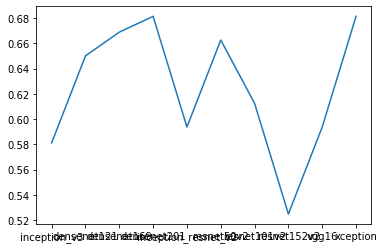

In [17]:
plt.plot(models_name, models_accuracy_val)

In [18]:
for i, history in enumerate(histories):
#     print ("modèle : ", models_name[i])

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

KeyError: 'acc'